AD (Test)


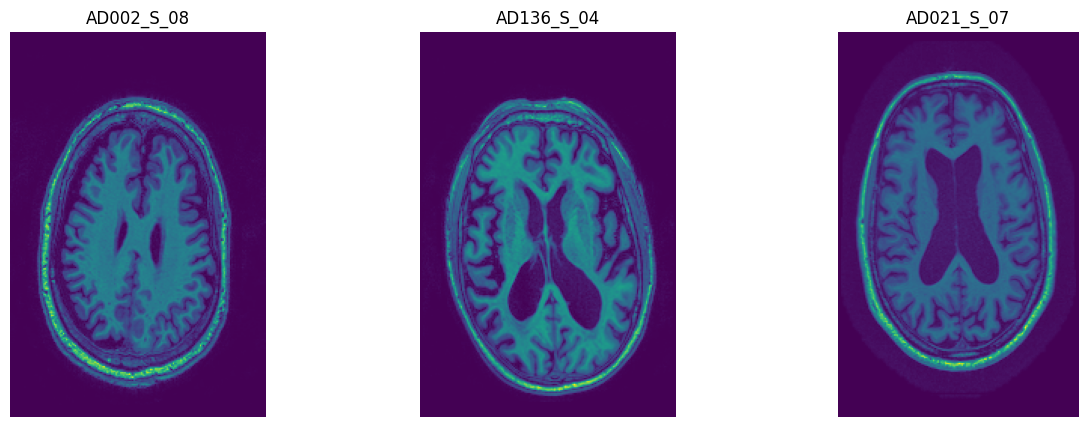

CN (Test)


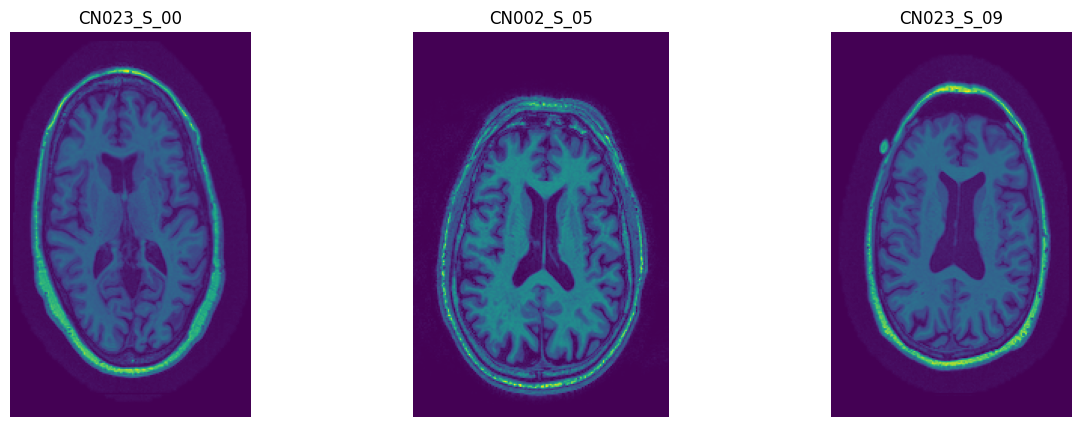

MCI (Test)


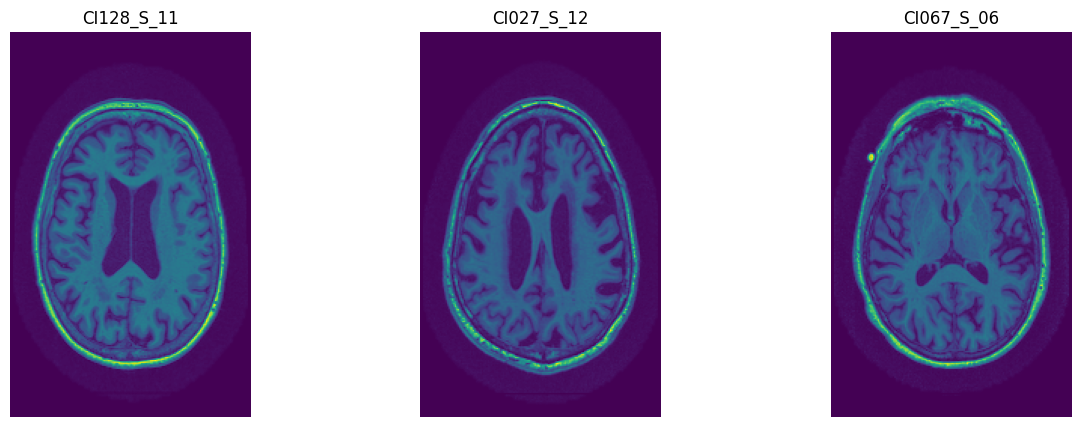

AD (Train)


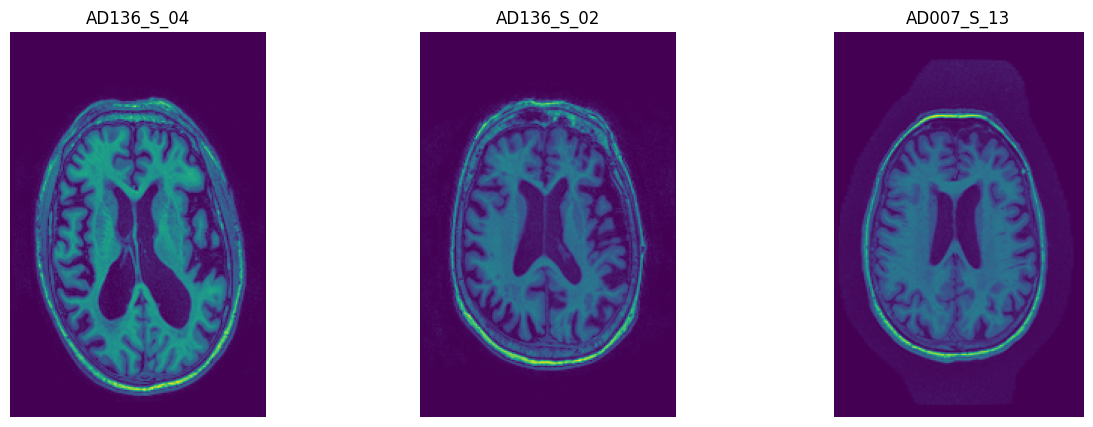

CN (Train)


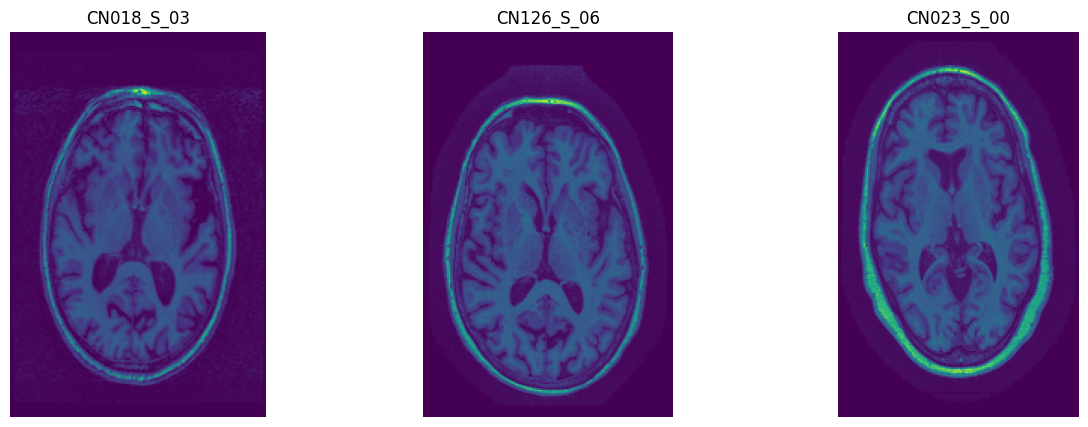

MCI (Train)


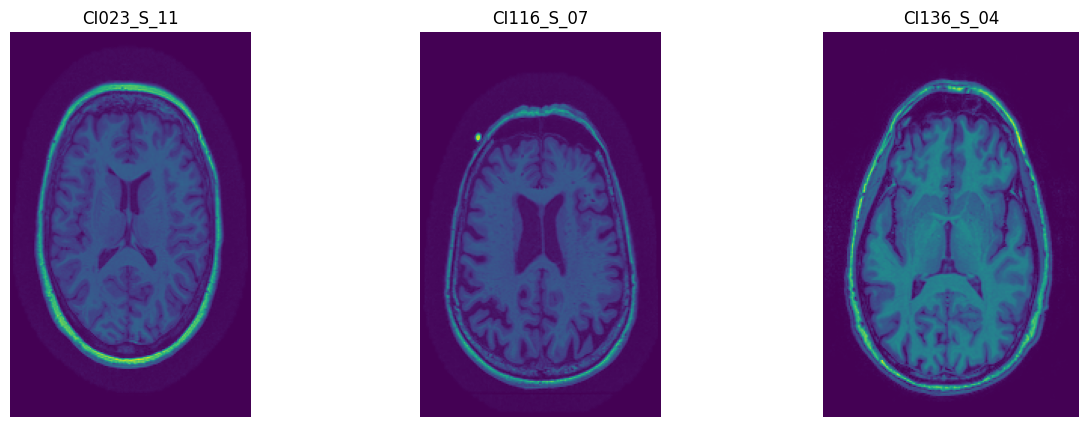

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

test_dir = "/kaggle/input/alzheimer-disease/test-20251010T094612Z-1-001/test"
train_dir = "/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train"


subfolders = ["AD", "CN", "MCI"]

# Function to show 3 images from each subfolder
def show_images_from_dir(path, n=3):
    files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    files = files[:n]  # Take only the first 3 images
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = Image.open(img_path)
        plt.subplot(1, len(files), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(file[:10])
    plt.show()


for subfolder in subfolders:
    print(f"{subfolder} (Test)")
    show_images_from_dir(os.path.join(test_dir, subfolder))


for subfolder in subfolders:
    print(f"{subfolder} (Train)")
    show_images_from_dir(os.path.join(train_dir, subfolder))

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
from collections import defaultdict
import torch  # For potential tensor operations, though minimal use here
import random  # For augmentation probe

# Set bold fonts for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# Define base directories
test_dir = "/kaggle/input/alzheimer-disease/test-20251010T094612Z-1-001/test"
train_dir = "/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train"
subfolders = ["AD", "CN", "MCI"]

# Helper function to get image paths for a directory and subfolder
def get_image_paths(base_dir, subfolder):
    folder_path = os.path.join(base_dir, subfolder)
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

Train - AD: RGB Mean [32.61346806 32.61346806 32.61346806], Std [41.3103727 41.3103727 41.3103727]
Train - AD: Brightness Mean 32.61346806125148, Contrast Mean 41.3103726971172
Train - AD: Avg Saturation Clipping Fraction 0.0


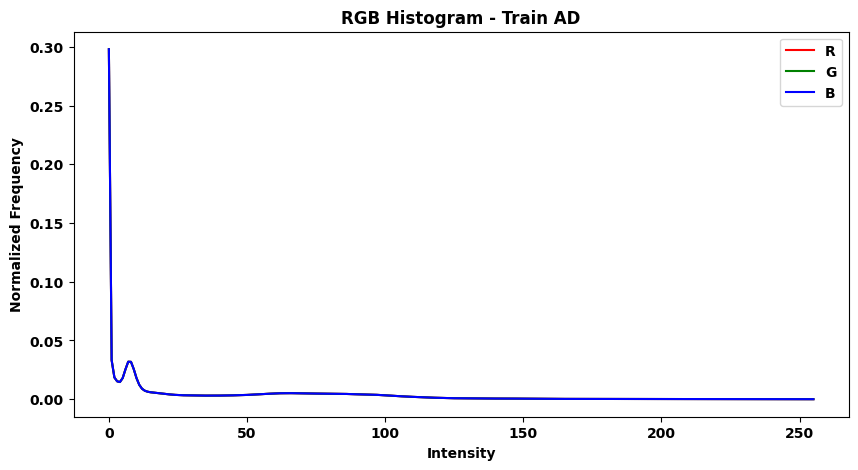

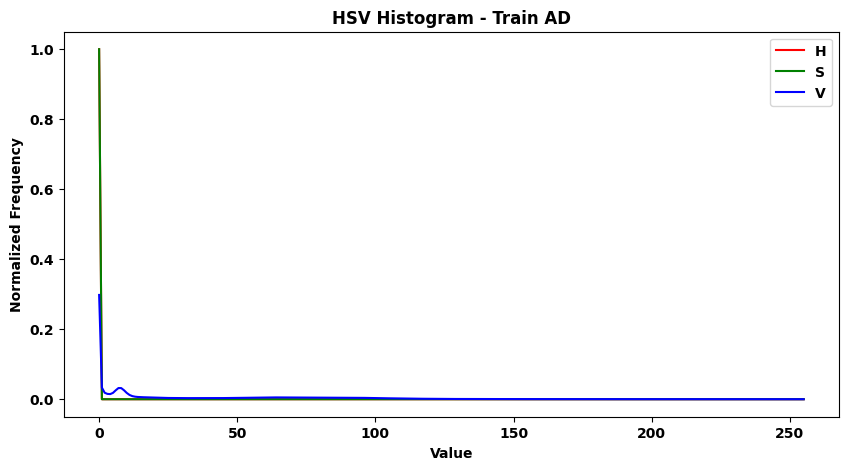

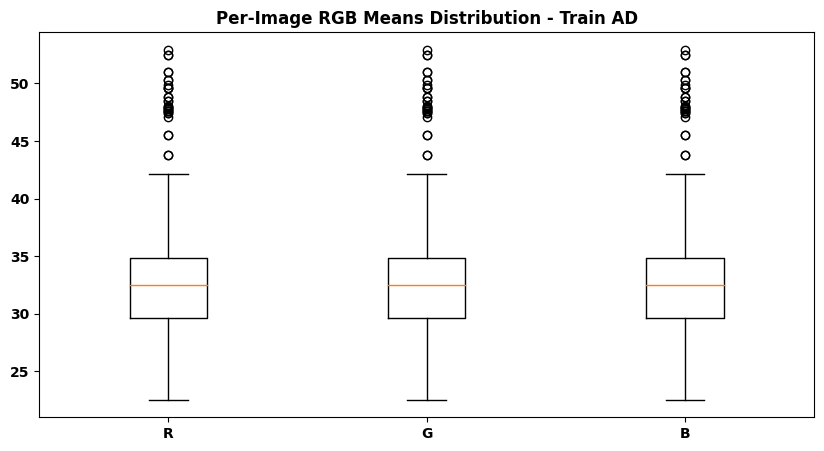

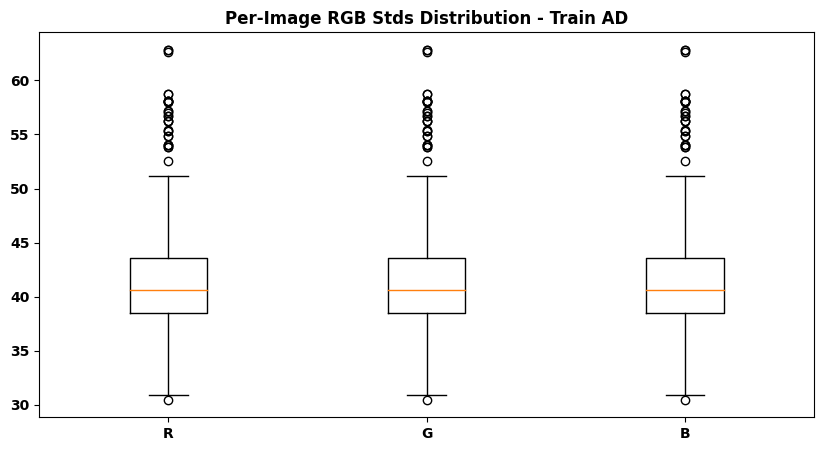

Train - CN: RGB Mean [32.45573519 32.45573519 32.45573519], Std [39.81537552 39.81537552 39.81537552]
Train - CN: Brightness Mean 32.45573518960173, Contrast Mean 39.815375524680924
Train - CN: Avg Saturation Clipping Fraction 0.0


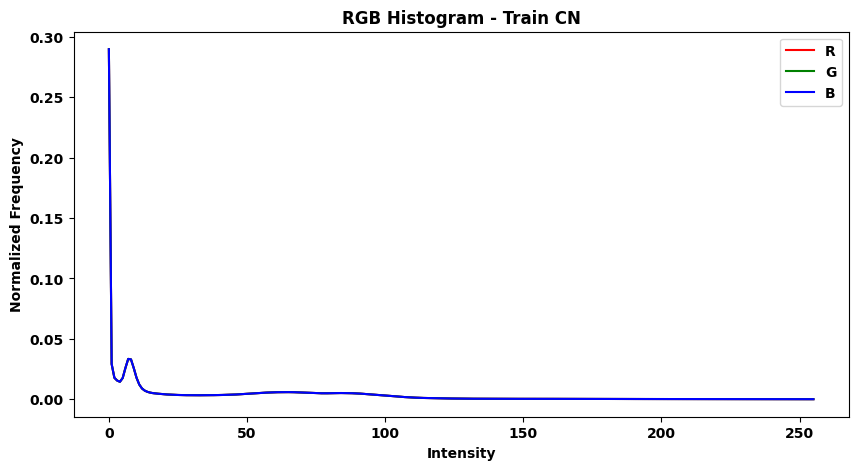

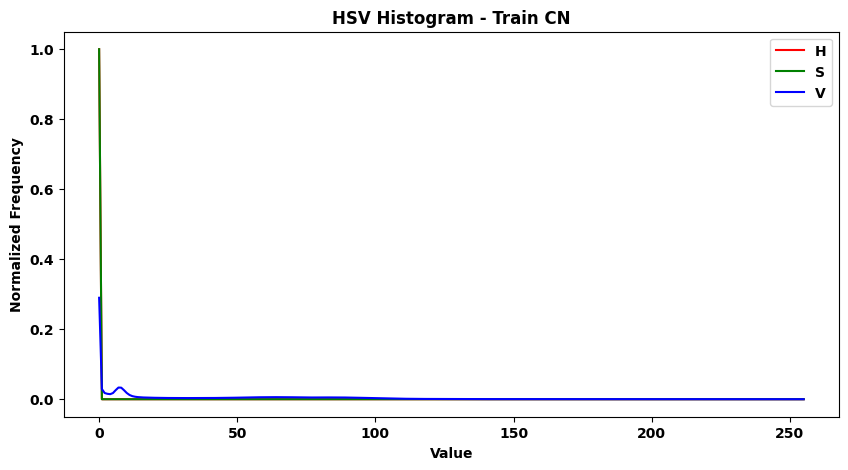

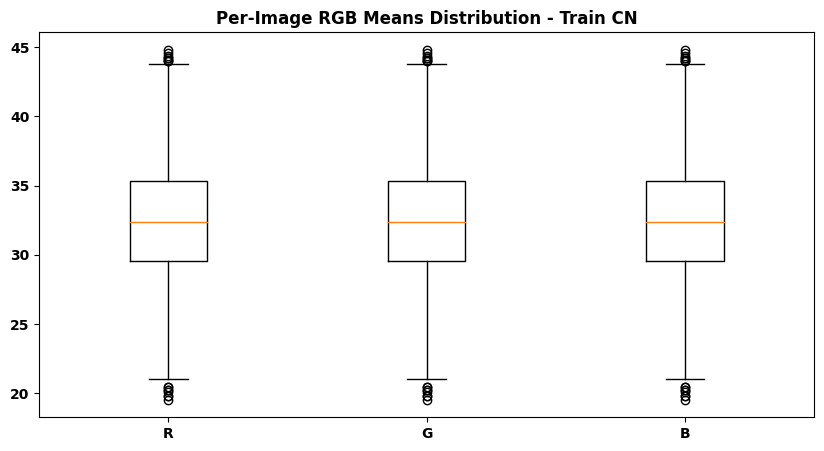

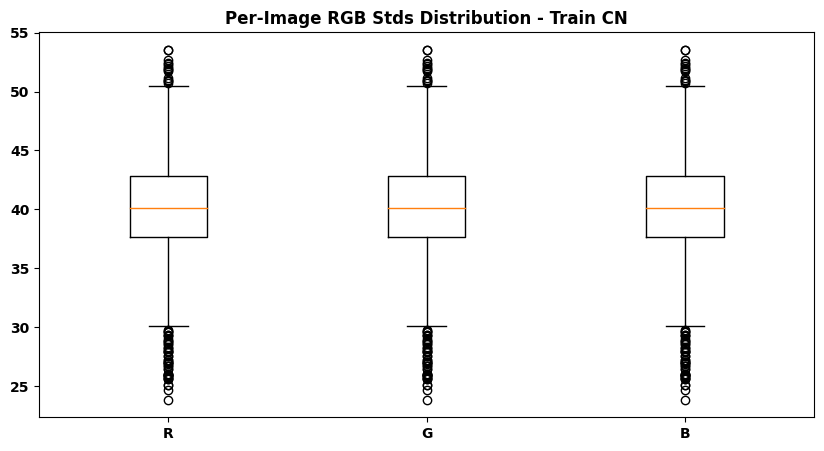

Train - MCI: RGB Mean [31.80549625 31.80549625 31.80549625], Std [38.97000707 38.97000707 38.97000707]
Train - MCI: Brightness Mean 31.805496254601, Contrast Mean 38.97000707295796
Train - MCI: Avg Saturation Clipping Fraction 0.0


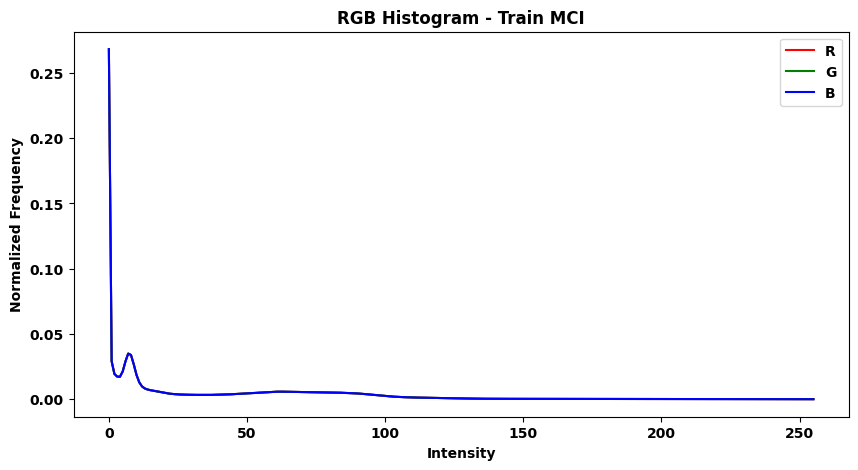

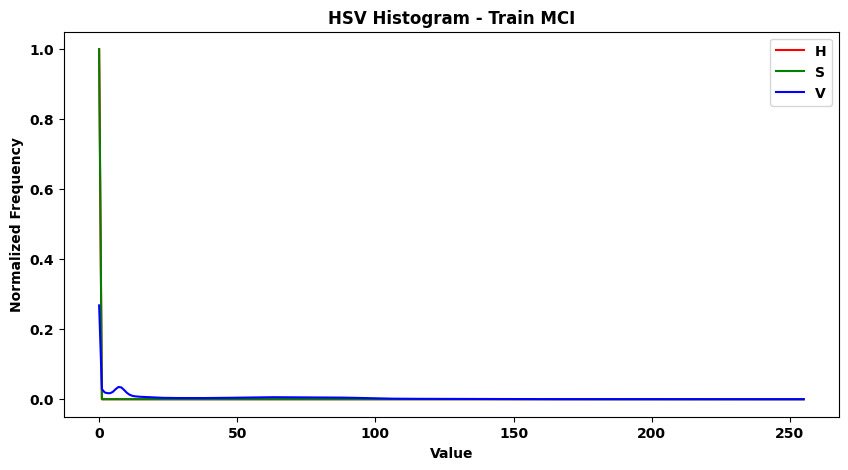

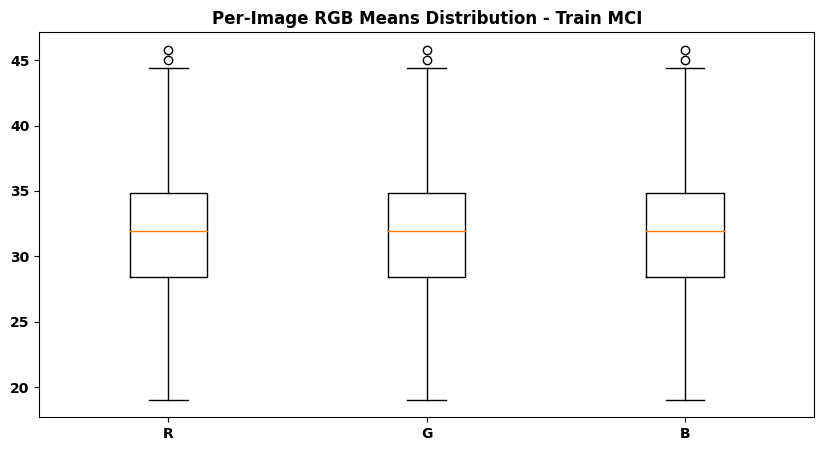

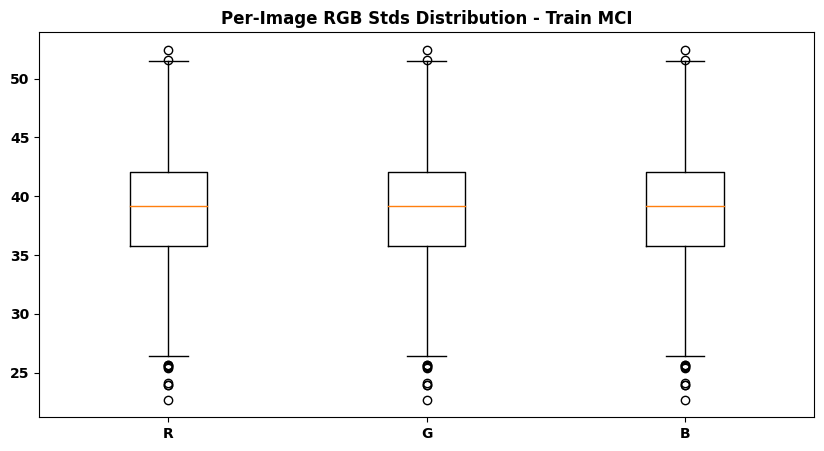

Test - AD: RGB Mean [32.82031287 32.82031287 32.82031287], Std [41.5914131 41.5914131 41.5914131]
Test - AD: Brightness Mean 32.82031286743174, Contrast Mean 41.5914131038512
Test - AD: Avg Saturation Clipping Fraction 0.0


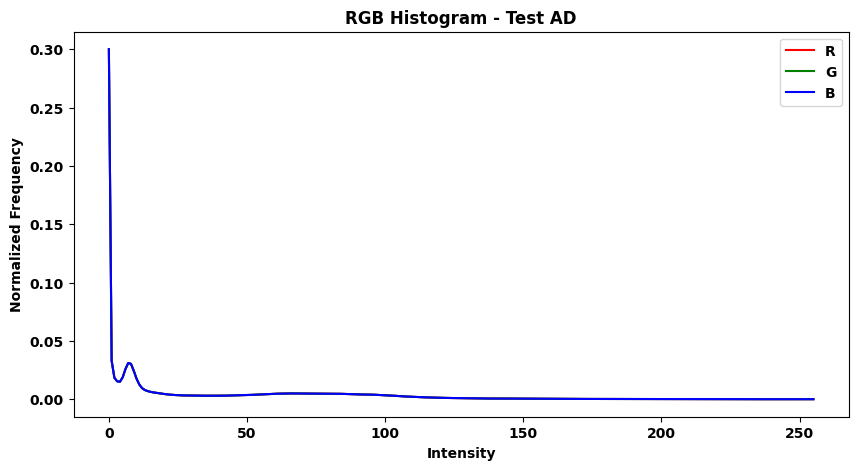

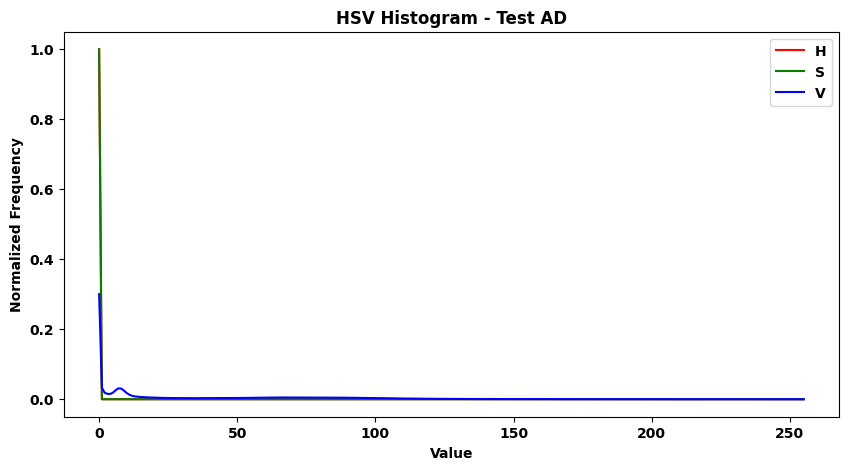

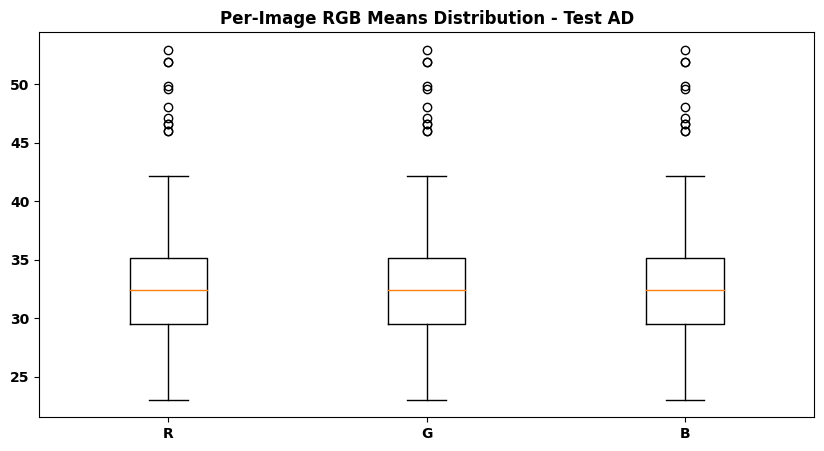

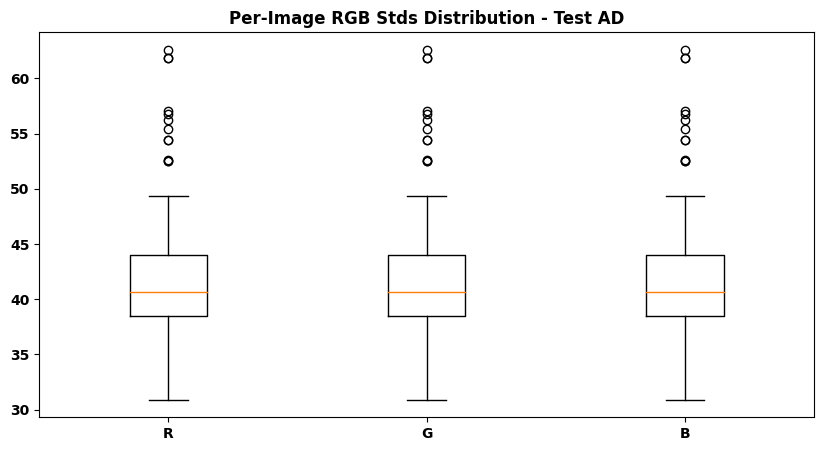

Test - CN: RGB Mean [32.50435488 32.50435488 32.50435488], Std [39.60195743 39.60195743 39.60195743]
Test - CN: Brightness Mean 32.50435487522047, Contrast Mean 39.601957426802976
Test - CN: Avg Saturation Clipping Fraction 0.0


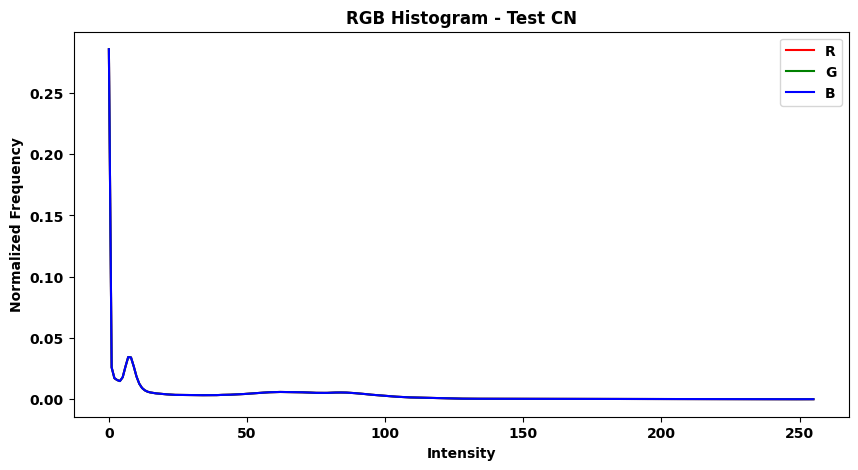

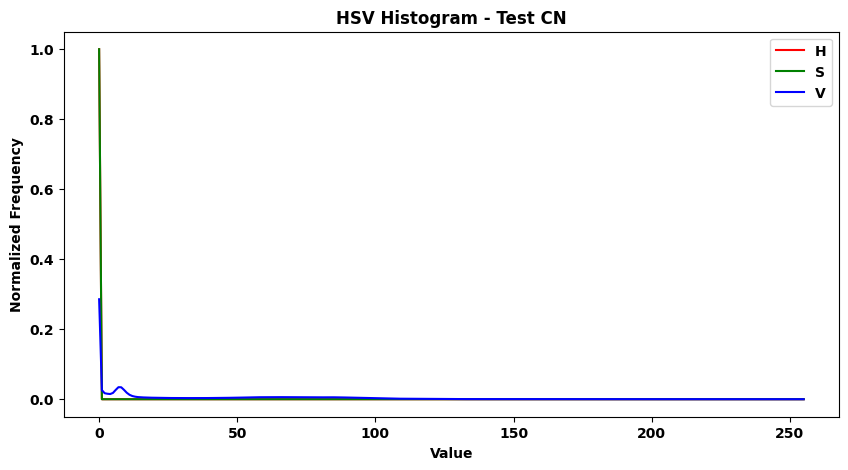

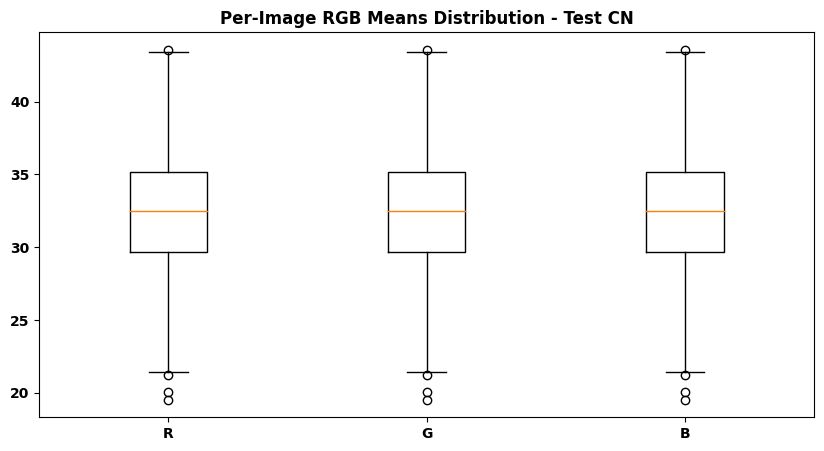

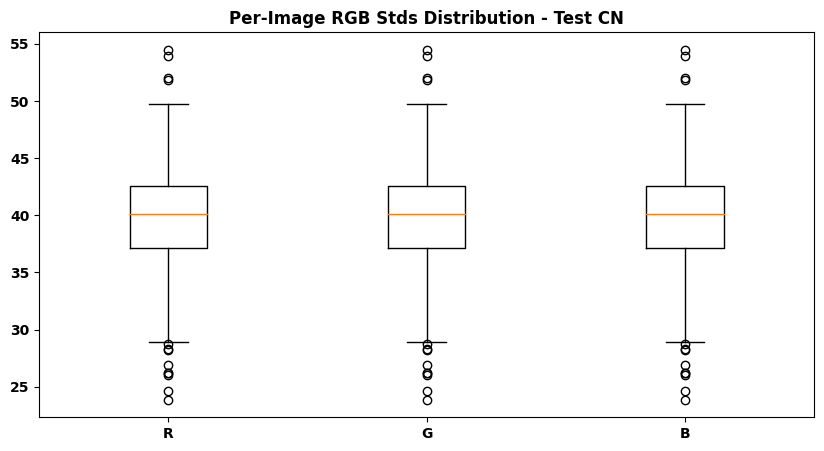

Test - MCI: RGB Mean [31.83111587 31.83111587 31.83111587], Std [39.36362054 39.36362054 39.36362054]
Test - MCI: Brightness Mean 31.831115868626625, Contrast Mean 39.36362054068896
Test - MCI: Avg Saturation Clipping Fraction 0.0


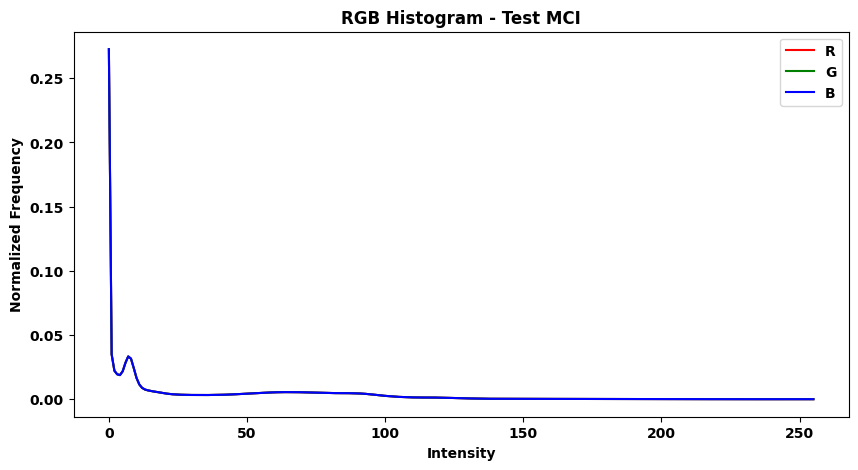

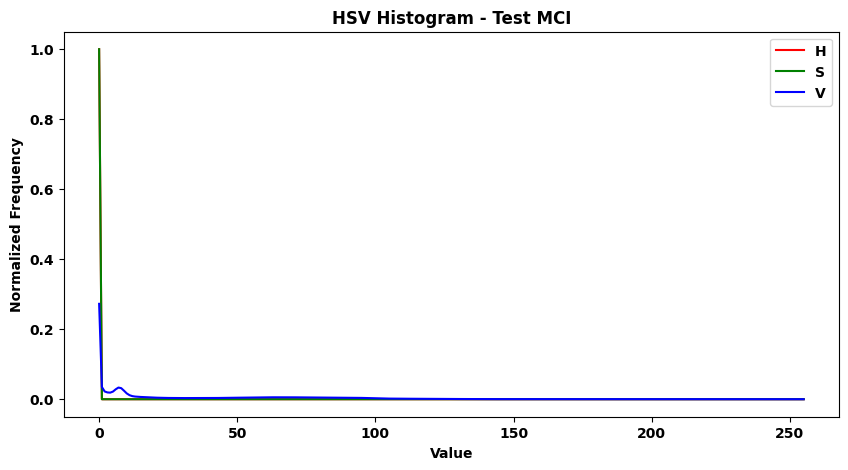

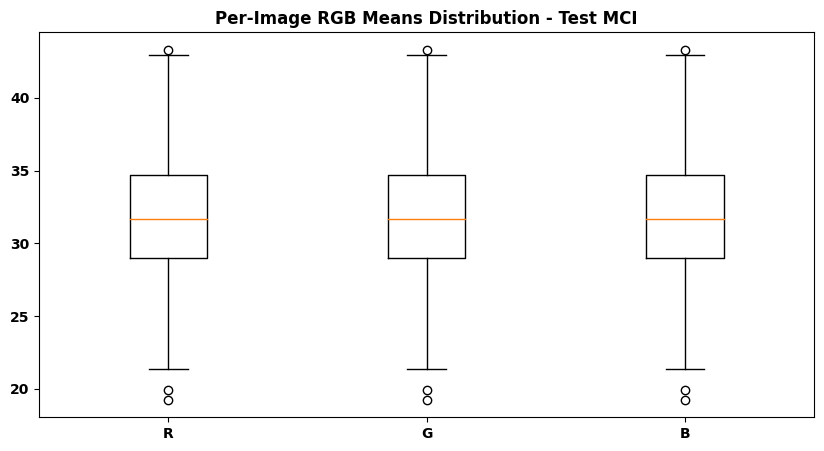

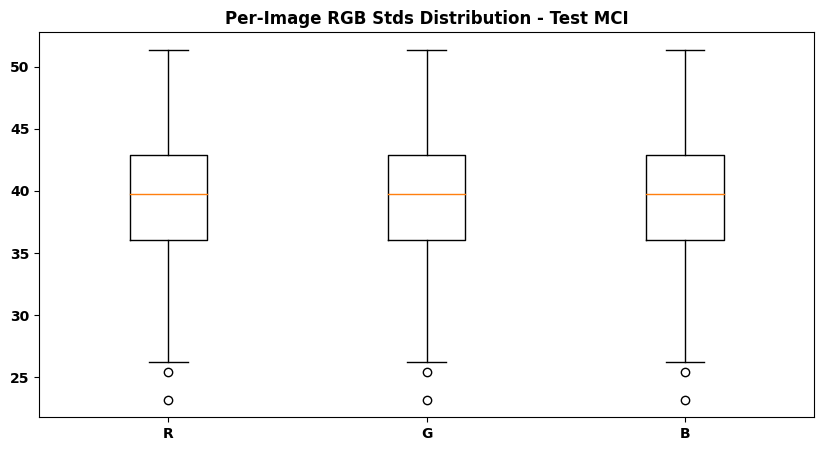

In [3]:
# Function to compute stats and histograms for a list of image paths
def compute_color_stats(image_paths, class_name, dataset_type):
    # For histograms (256 bins per channel)
    rgb_hist = [np.zeros(256) for _ in range(3)]  # R, G, B
    hsv_hist = [np.zeros(256) for _ in range(3)]  # H, S, V
    per_image_rgb_means = []
    per_image_rgb_stds = []
    per_image_brightness = []  # V mean
    per_image_contrast = []  # V std
    saturation_clipping_frac = 0.0
    total_pixels = 0

    for img_path in image_paths:
        img = np.array(Image.open(img_path).convert('RGB'))
        h, w, _ = img.shape
        pixels = h * w
        total_pixels += pixels

        # RGB stats
        rgb_mean = np.mean(img, axis=(0,1))
        rgb_std = np.std(img, axis=(0,1))
        per_image_rgb_means.append(rgb_mean)
        per_image_rgb_stds.append(rgb_std)

        for ch in range(3):
            ch_hist, _ = np.histogram(img[..., ch], bins=256, range=(0, 255))
            rgb_hist[ch] += ch_hist

        # HSV (using PIL convert)
        hsv_img = np.array(Image.fromarray(img).convert('HSV'))  # H:0-255, S:0-255, V:0-255
        brightness = np.mean(hsv_img[..., 2])
        contrast = np.std(hsv_img[..., 2])
        per_image_brightness.append(brightness)
        per_image_contrast.append(contrast)

        for ch in range(3):
            ch_hist, _ = np.histogram(hsv_img[..., ch], bins=256, range=(0, 255))
            hsv_hist[ch] += ch_hist

        # Saturation clipping (pixels with S > 250)
        sat_clipped = np.sum(hsv_img[..., 1] > 250)
        saturation_clipping_frac += sat_clipped / pixels

    # Normalize histograms
    for ch in range(3):
        rgb_hist[ch] /= total_pixels
        hsv_hist[ch] /= total_pixels

    # Per-class mean/std (weighted)
    class_rgb_mean = np.mean(per_image_rgb_means, axis=0)
    class_rgb_std = np.mean(per_image_rgb_stds, axis=0)
    class_brightness_mean = np.mean(per_image_brightness)
    class_contrast_mean = np.mean(per_image_contrast)
    saturation_clipping_frac /= len(image_paths)  # Average per image

    # Print summaries
    print(f"{dataset_type} - {class_name}: RGB Mean {class_rgb_mean}, Std {class_rgb_std}")
    print(f"{dataset_type} - {class_name}: Brightness Mean {class_brightness_mean}, Contrast Mean {class_contrast_mean}")
    print(f"{dataset_type} - {class_name}: Avg Saturation Clipping Fraction {saturation_clipping_frac}")

    # Plot RGB Histogram
    plt.figure(figsize=(10, 5))
    plt.plot(rgb_hist[0], color='red', label='R')
    plt.plot(rgb_hist[1], color='green', label='G')
    plt.plot(rgb_hist[2], color='blue', label='B')
    plt.title(f'RGB Histogram - {dataset_type} {class_name}')
    plt.xlabel('Intensity')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()

    # Plot HSV Histogram
    plt.figure(figsize=(10, 5))
    plt.plot(hsv_hist[0], color='red', label='H')
    plt.plot(hsv_hist[1], color='green', label='S')
    plt.plot(hsv_hist[2], color='blue', label='V')
    plt.title(f'HSV Histogram - {dataset_type} {class_name}')
    plt.xlabel('Value')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()

    # Plot per-image mean/std distributions (boxplots)
    plt.figure(figsize=(10, 5))
    plt.boxplot(np.array(per_image_rgb_means), labels=['R', 'G', 'B'])
    plt.title(f'Per-Image RGB Means Distribution - {dataset_type} {class_name}')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.boxplot(np.array(per_image_rgb_stds), labels=['R', 'G', 'B'])
    plt.title(f'Per-Image RGB Stds Distribution - {dataset_type} {class_name}')
    plt.show()

# Run for train and test
for dataset_type, base_dir in [("Train", train_dir), ("Test", test_dir)]:
    for sub in subfolders:
        paths = get_image_paths(base_dir, sub)
        compute_color_stats(paths, sub, dataset_type)

Train - AD: Median Resolution 160.0x256.0, Mean Aspect Ratio 0.6414418798665183
Suggested Strategy for AD: Resize to 160.0x256.0 with padding to preserve aspect ratio. Class-wise effects: If variances high, padding prevents distortion in AD.


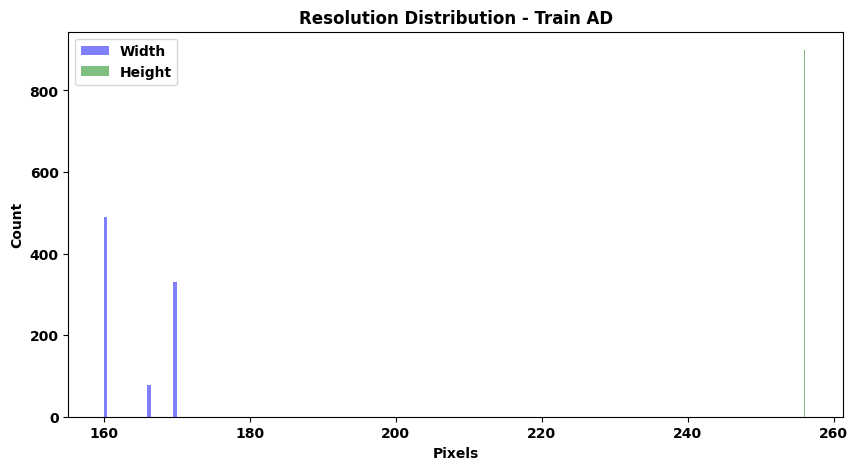

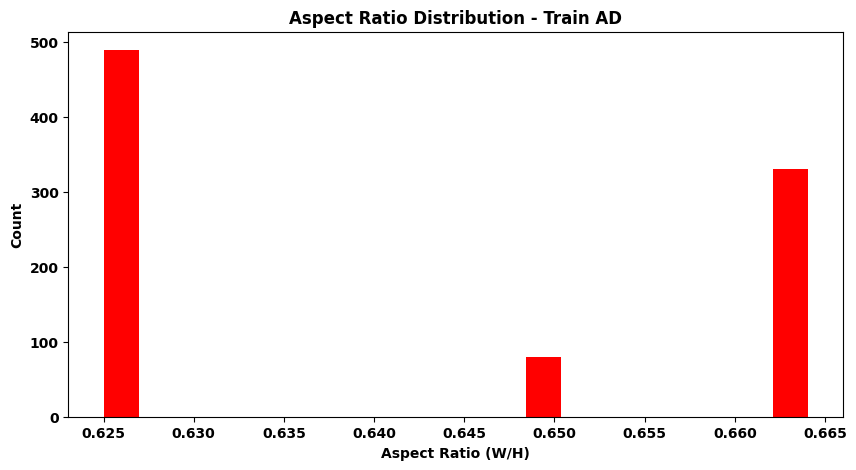

Train - CN: Median Resolution 166.0x256.0, Mean Aspect Ratio 0.6425577799479166
Suggested Strategy for CN: Resize to 166.0x256.0 with padding to preserve aspect ratio. Class-wise effects: If variances high, padding prevents distortion in CN.


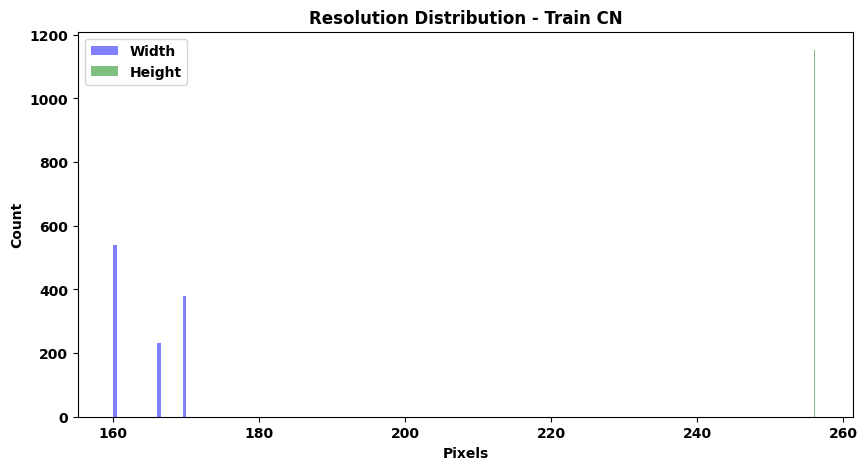

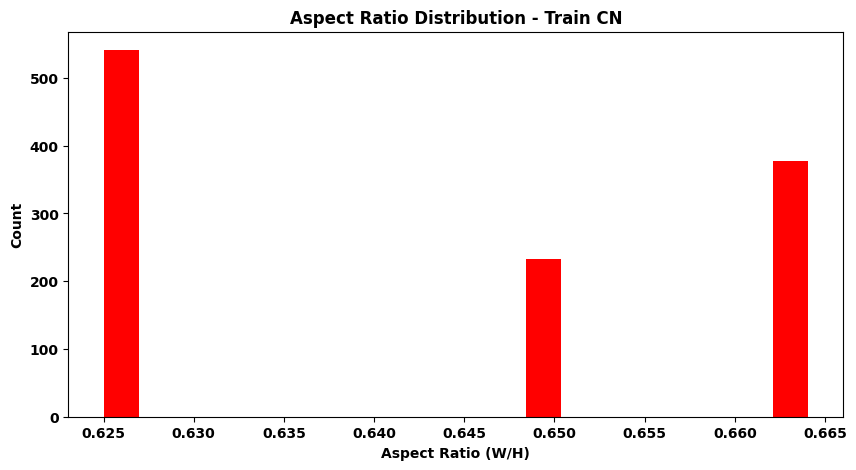

Train - MCI: Median Resolution 160.0x256.0, Mean Aspect Ratio 0.638999909507722
Suggested Strategy for MCI: Resize to 160.0x256.0 with padding to preserve aspect ratio. Class-wise effects: If variances high, padding prevents distortion in MCI.


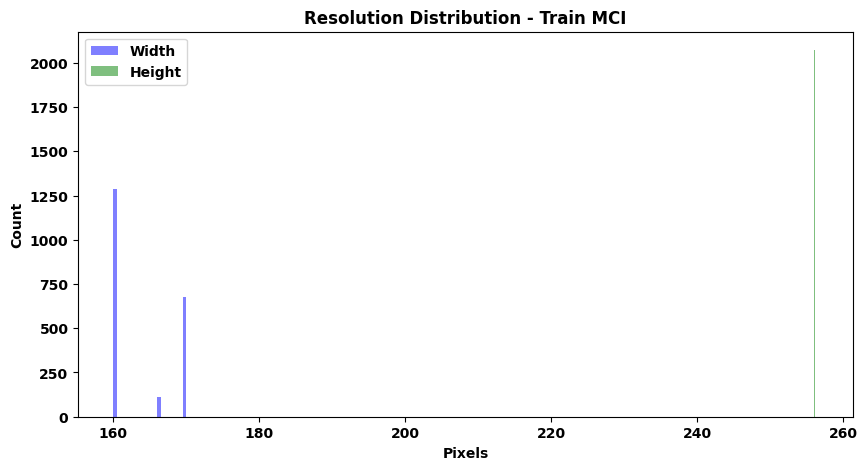

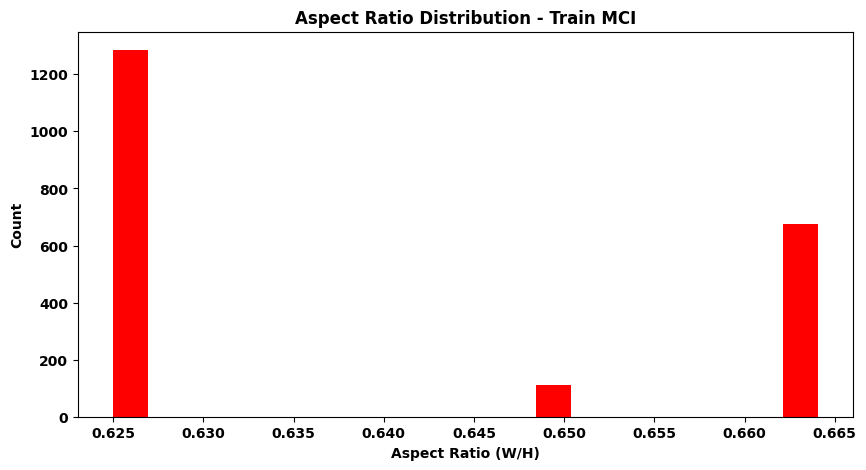

Test - AD: Median Resolution 166.0x256.0, Mean Aspect Ratio 0.6428125
Suggested Strategy for AD: Resize to 166.0x256.0 with padding to preserve aspect ratio. Class-wise effects: If variances high, padding prevents distortion in AD.


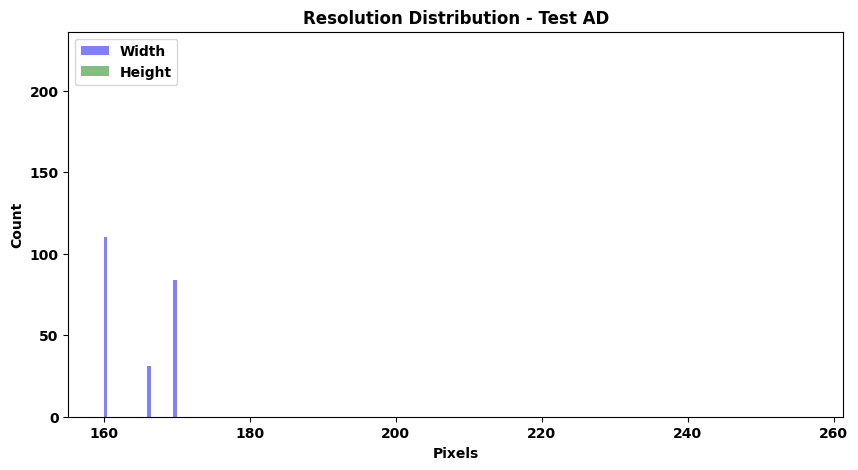

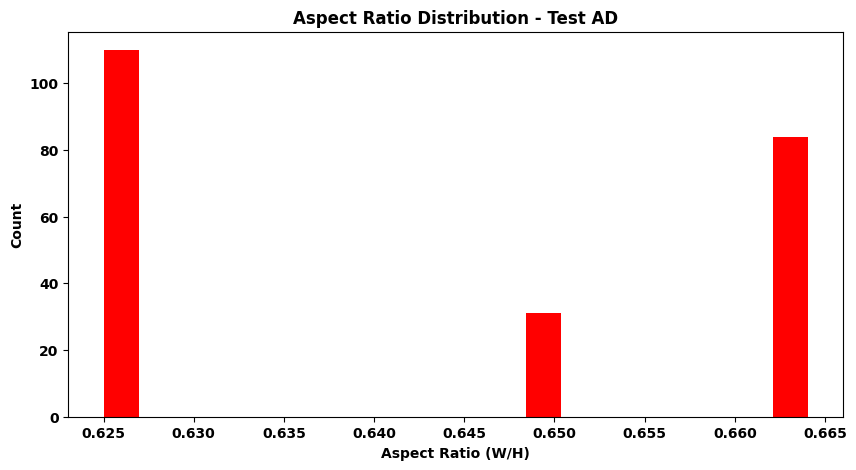

Test - CN: Median Resolution 166.0x256.0, Mean Aspect Ratio 0.6416558159722222
Suggested Strategy for CN: Resize to 166.0x256.0 with padding to preserve aspect ratio. Class-wise effects: If variances high, padding prevents distortion in CN.


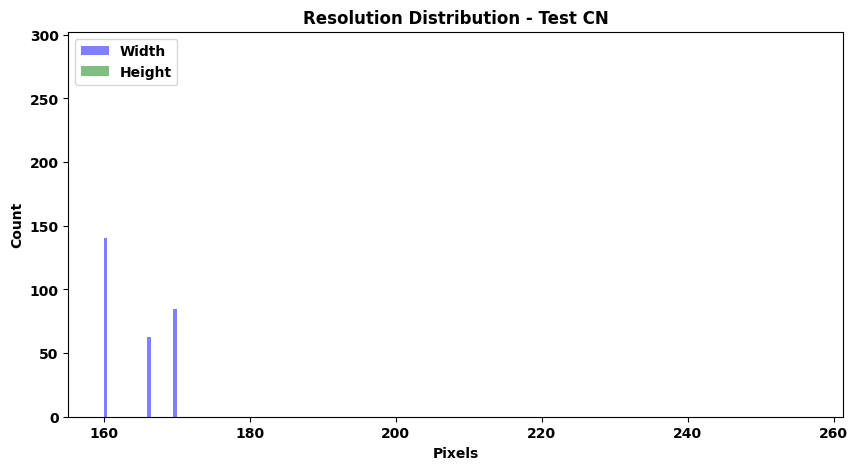

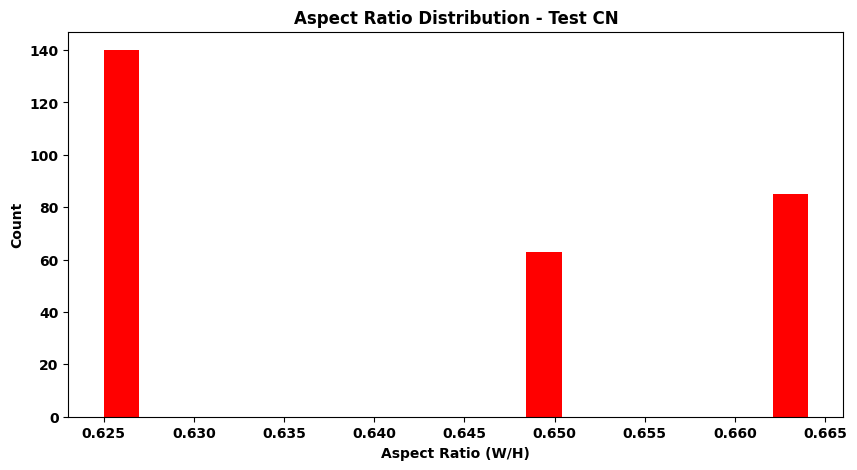

Test - MCI: Median Resolution 160.0x256.0, Mean Aspect Ratio 0.6418918918918919
Suggested Strategy for MCI: Resize to 160.0x256.0 with padding to preserve aspect ratio. Class-wise effects: If variances high, padding prevents distortion in MCI.


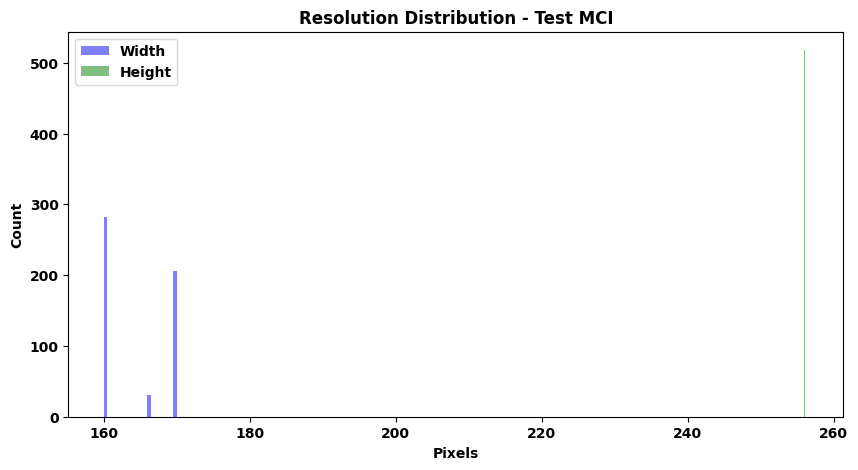

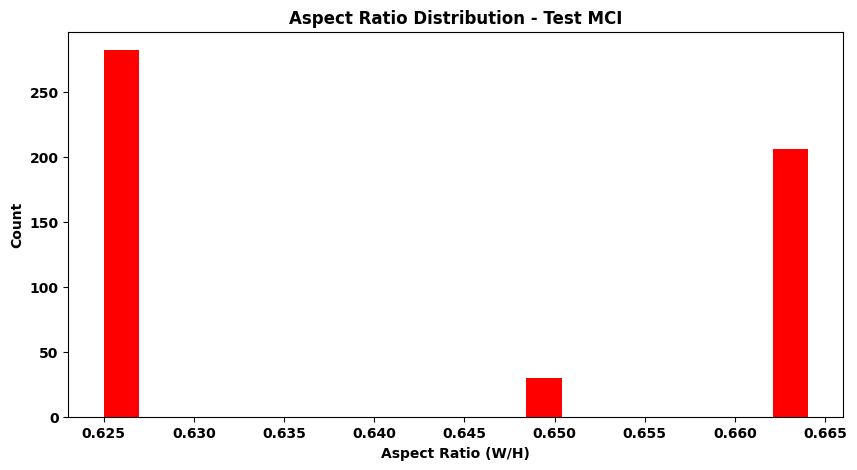

In [4]:
# Function to compute resolution and aspect ratio stats
def compute_resolution_stats(image_paths, class_name, dataset_type):
    resolutions = []
    aspect_ratios = []
    for img_path in image_paths:
        img = Image.open(img_path)
        w, h = img.size
        resolutions.append((w, h))
        aspect_ratios.append(w / h if h != 0 else 0)

    # Median resolution for strategy
    widths = [r[0] for r in resolutions]
    heights = [r[1] for r in resolutions]
    median_w = np.median(widths)
    median_h = np.median(heights)
    print(f"{dataset_type} - {class_name}: Median Resolution {median_w}x{median_h}, Mean Aspect Ratio {np.mean(aspect_ratios)}")

    # Suggest strategy
    print(f"Suggested Strategy for {class_name}: Resize to {median_w}x{median_h} with padding to preserve aspect ratio. Class-wise effects: If variances high, padding prevents distortion in {class_name}.")

    # Plot distributions
    plt.figure(figsize=(10, 5))
    plt.hist(widths, bins=20, color='blue', alpha=0.5, label='Width')
    plt.hist(heights, bins=20, color='green', alpha=0.5, label='Height')
    plt.title(f'Resolution Distribution - {dataset_type} {class_name}')
    plt.xlabel('Pixels')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(aspect_ratios, bins=20, color='red')
    plt.title(f'Aspect Ratio Distribution - {dataset_type} {class_name}')
    plt.xlabel('Aspect Ratio (W/H)')
    plt.ylabel('Count')
    plt.show()

# Run for train and test
for dataset_type, base_dir in [("Train", train_dir), ("Test", test_dir)]:
    for sub in subfolders:
        paths = get_image_paths(base_dir, sub)
        compute_resolution_stats(paths, sub, dataset_type)

Train - AD: Mean Sharpness (Laplacian Var) 957.1282744615885, Mean Noise Proxy 14.802802645471242


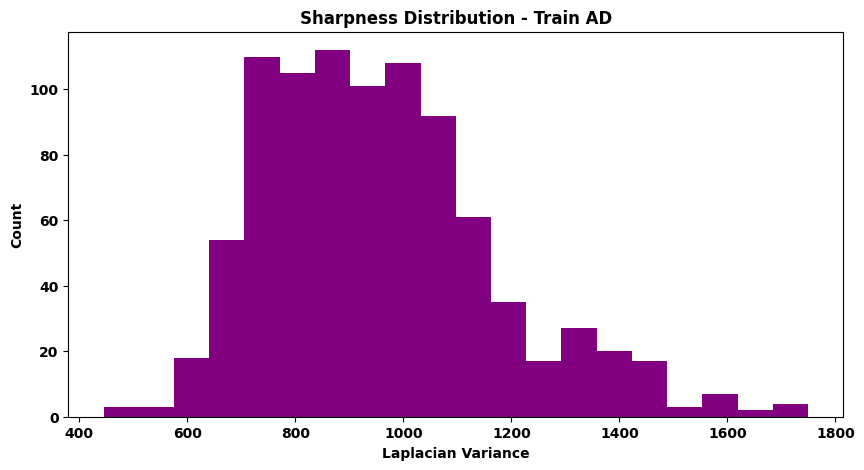

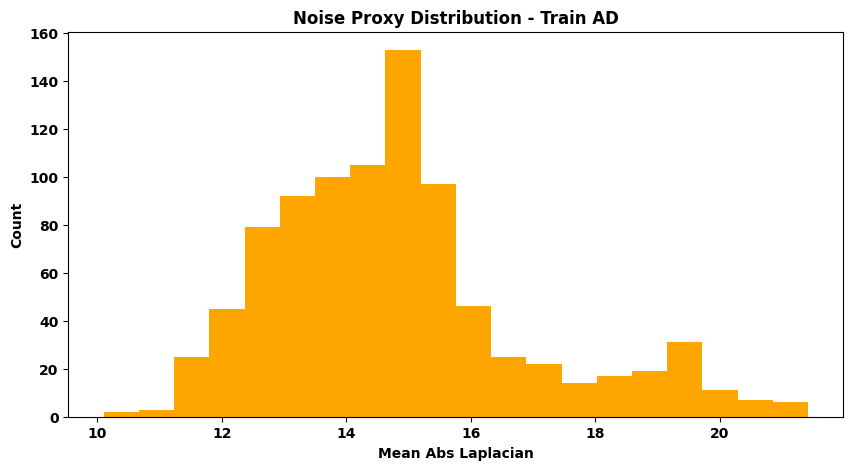

Train - CN: Mean Sharpness (Laplacian Var) 893.2968455190498, Mean Noise Proxy 14.251108631410697


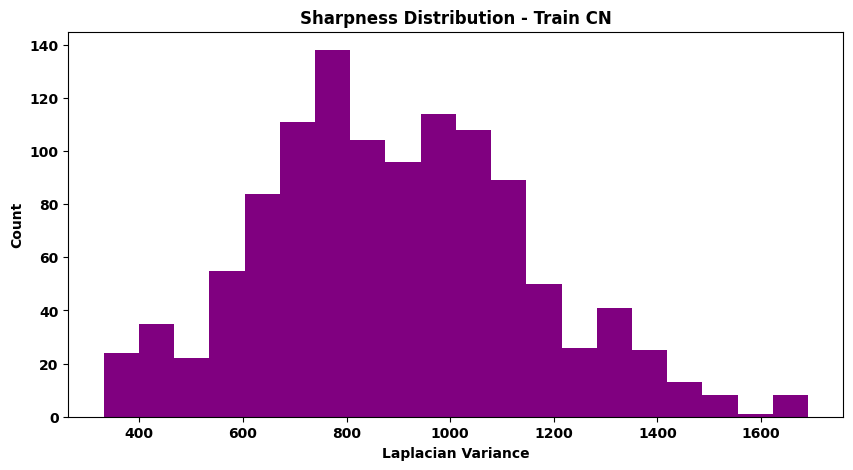

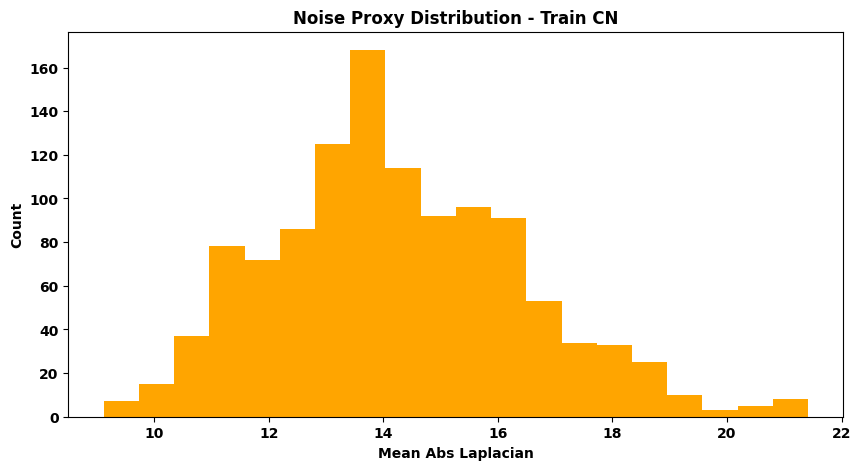

Train - MCI: Mean Sharpness (Laplacian Var) 908.4466331019075, Mean Noise Proxy 14.612884490720369


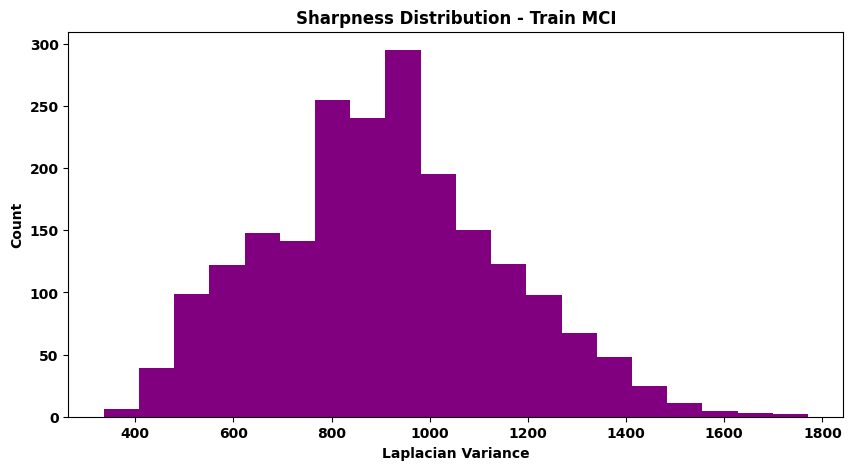

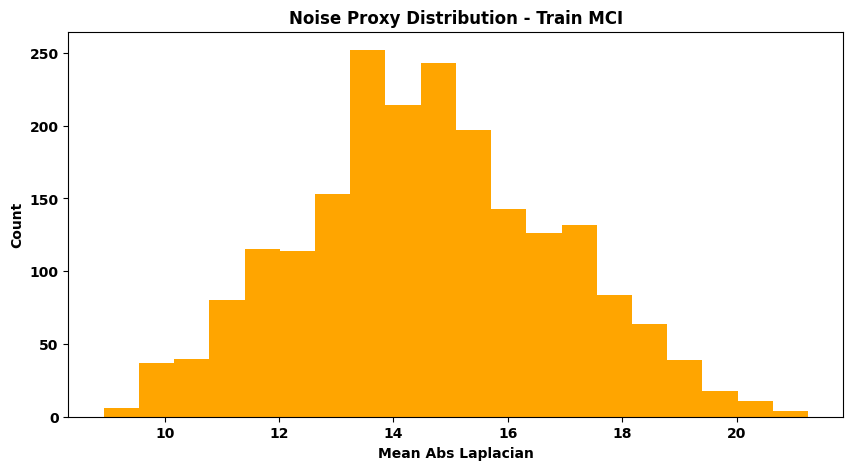

Test - AD: Mean Sharpness (Laplacian Var) 951.997204343723, Mean Noise Proxy 14.780007986757077


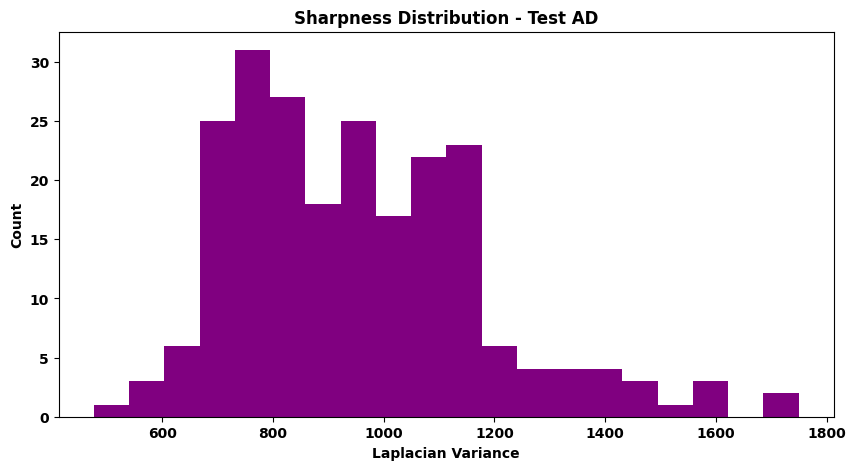

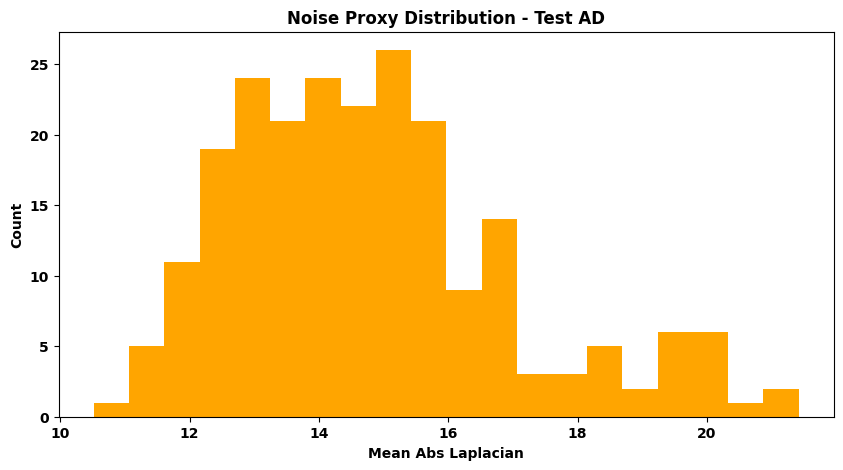

Test - CN: Mean Sharpness (Laplacian Var) 905.8616302025225, Mean Noise Proxy 14.30359284211467


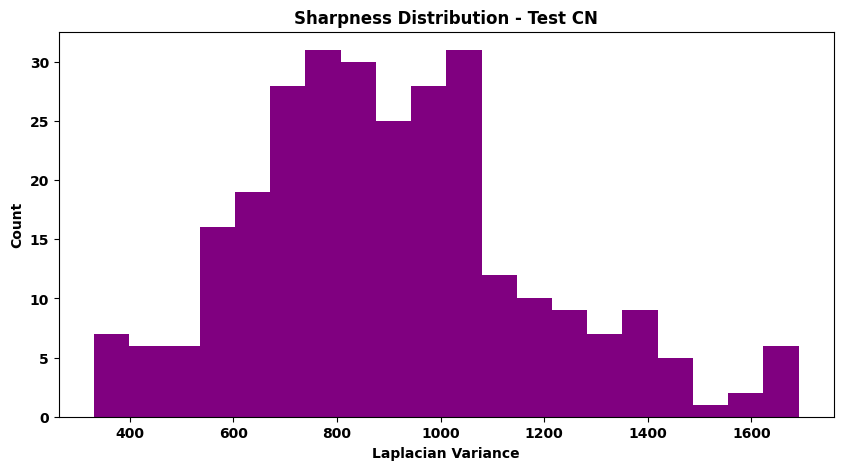

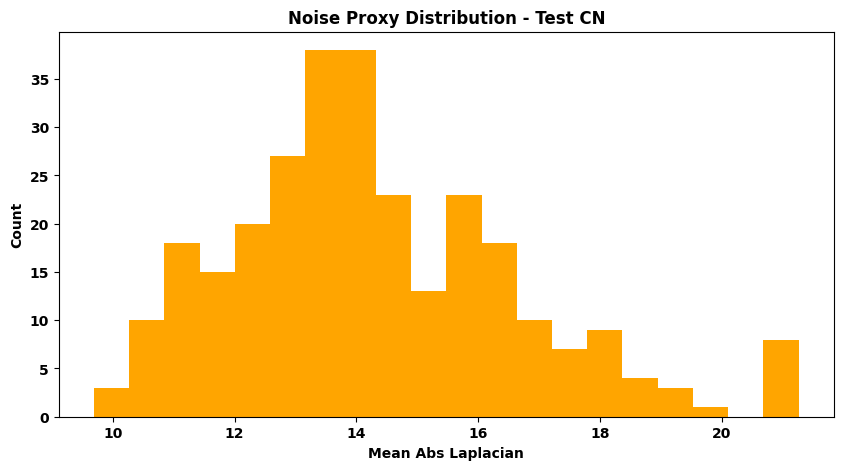

Test - MCI: Mean Sharpness (Laplacian Var) 915.2936486167289, Mean Noise Proxy 14.626260219342337


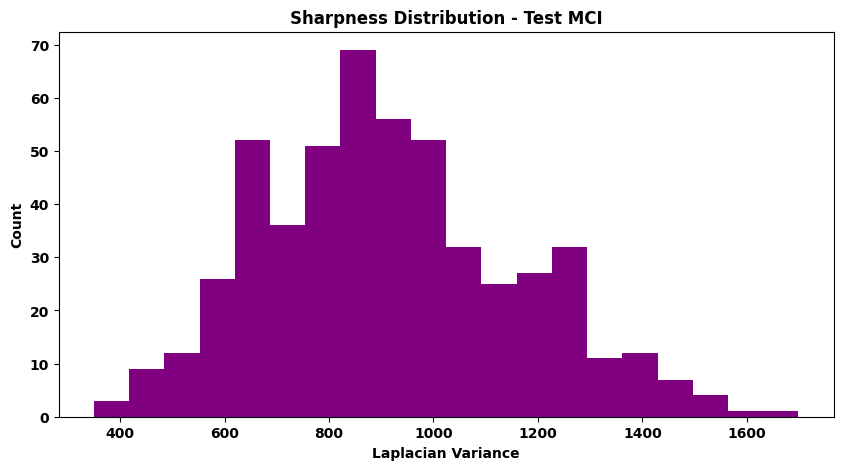

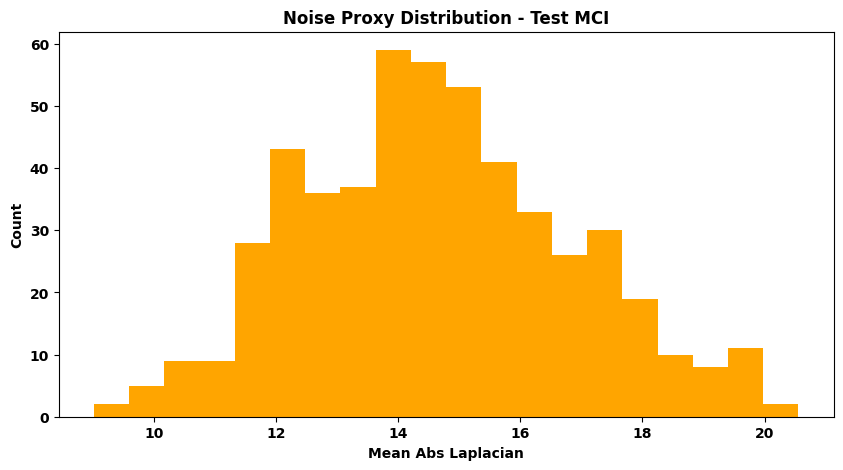

In [5]:
# Function to compute sharpness and noise
def compute_sharpness_noise(image_paths, class_name, dataset_type):
    sharpness_values = []
    noise_values = []  # Proxy as abs(Laplacian) mean
    for img_path in image_paths:
        img = np.array(Image.open(img_path).convert('L'))  # Grayscale
        laplacian = ndimage.laplace(img.astype(float))
        sharpness = np.var(laplacian)
        noise_proxy = np.mean(np.abs(laplacian))
        sharpness_values.append(sharpness)
        noise_values.append(noise_proxy)

    print(f"{dataset_type} - {class_name}: Mean Sharpness (Laplacian Var) {np.mean(sharpness_values)}, Mean Noise Proxy {np.mean(noise_values)}")

    # Plot distributions
    plt.figure(figsize=(10, 5))
    plt.hist(sharpness_values, bins=20, color='purple')
    plt.title(f'Sharpness Distribution - {dataset_type} {class_name}')
    plt.xlabel('Laplacian Variance')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(noise_values, bins=20, color='orange')
    plt.title(f'Noise Proxy Distribution - {dataset_type} {class_name}')
    plt.xlabel('Mean Abs Laplacian')
    plt.ylabel('Count')
    plt.show()

# Run for train and test
for dataset_type, base_dir in [("Train", train_dir), ("Test", test_dir)]:
    for sub in subfolders:
        paths = get_image_paths(base_dir, sub)
        compute_sharpness_noise(paths, sub, dataset_type)

Train - AD: Avg Channel Means [32.61346806 32.61346806 32.61346806], Gray-World Deviation 0.0 (lower is better balanced)


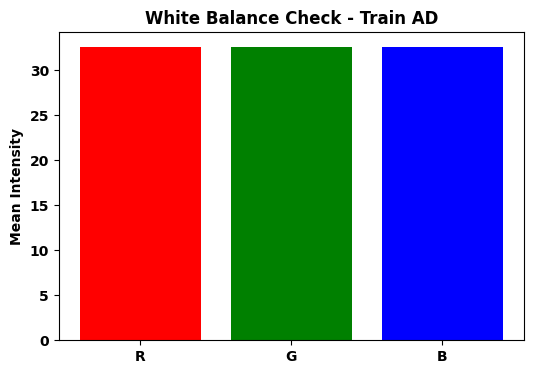

Train - CN: Avg Channel Means [32.45573519 32.45573519 32.45573519], Gray-World Deviation 0.0 (lower is better balanced)


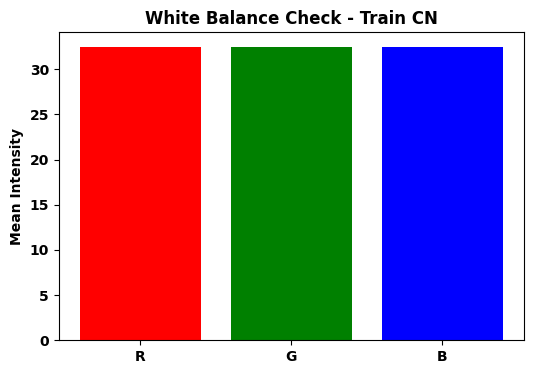

Train - MCI: Avg Channel Means [31.80549625 31.80549625 31.80549625], Gray-World Deviation 3.552713678800501e-15 (lower is better balanced)


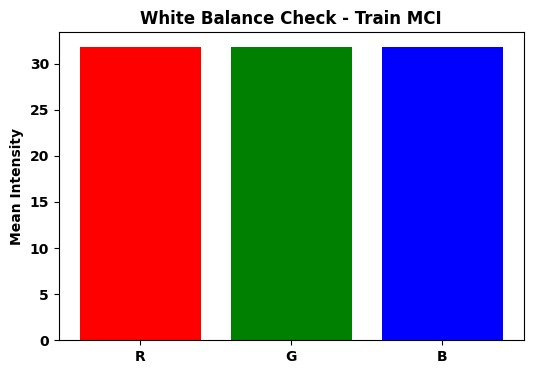

Test - AD: Avg Channel Means [32.82031287 32.82031287 32.82031287], Gray-World Deviation 0.0 (lower is better balanced)


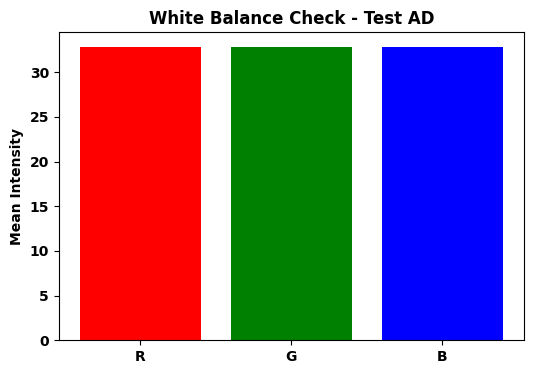

Test - CN: Avg Channel Means [32.50435488 32.50435488 32.50435488], Gray-World Deviation 0.0 (lower is better balanced)


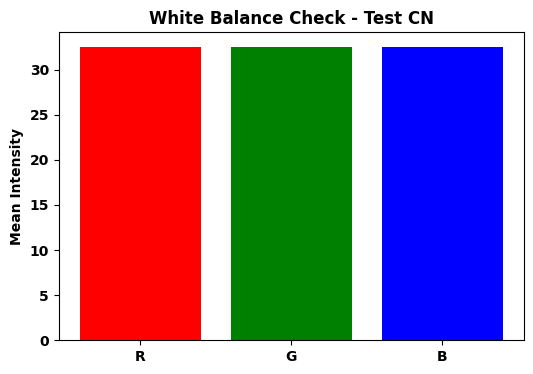

Test - MCI: Avg Channel Means [31.83111587 31.83111587 31.83111587], Gray-World Deviation 0.0 (lower is better balanced)


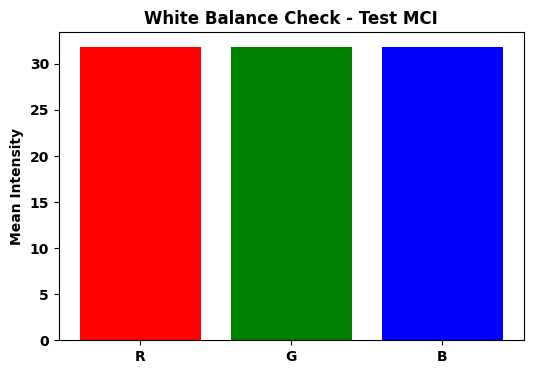

In [6]:
# Function for white balance check
def compute_white_balance(image_paths, class_name, dataset_type):
    channel_means = []
    for img_path in image_paths:
        img = np.array(Image.open(img_path).convert('RGB'))
        means = np.mean(img, axis=(0,1))
        channel_means.append(means)

    avg_means = np.mean(channel_means, axis=0)
    deviation = np.std(avg_means)  # Deviation from equal
    print(f"{dataset_type} - {class_name}: Avg Channel Means {avg_means}, Gray-World Deviation {deviation} (lower is better balanced)")

    # Plot bar
    plt.figure(figsize=(6, 4))
    plt.bar(['R', 'G', 'B'], avg_means, color=['red', 'green', 'blue'])
    plt.title(f'White Balance Check - {dataset_type} {class_name}')
    plt.ylabel('Mean Intensity')
    plt.show()

# Run for train and test
for dataset_type, base_dir in [("Train", train_dir), ("Test", test_dir)]:
    for sub in subfolders:
        paths = get_image_paths(base_dir, sub)
        compute_white_balance(paths, sub, dataset_type)

In [7]:
# Function for perceptual hash (dHash)
def dhash(image, hash_size=8):
    img = Image.open(image).convert('L').resize((hash_size + 1, hash_size), Image.LANCZOS)
    pixels = np.array(img)
    diff = pixels[:, 1:] > pixels[:, :-1]
    return ''.join(str(int(b)) for row in diff for b in row)

# Function to detect duplicates
def detect_duplicates(image_paths, class_name, dataset_type):
    hash_dict = defaultdict(list)
    for img_path in image_paths:
        h = dhash(img_path)
        hash_dict[h].append(img_path)

    duplicates = {h: paths for h, paths in hash_dict.items() if len(paths) > 1}
    print(f"{dataset_type} - {class_name}: Found {len(duplicates)} duplicate groups")
    for group in duplicates.values():
        print(f"Duplicates: {group}")

# Run for train and test
for dataset_type, base_dir in [("Train", train_dir), ("Test", test_dir)]:
    for sub in subfolders:
        paths = get_image_paths(base_dir, sub)
        detect_duplicates(paths, sub, dataset_type)

Train - AD: Found 198 duplicate groups
Duplicates: ['/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD136_S_0426a120.png', '/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD136_S_0426b120.png']
Duplicates: ['/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD136_S_0299a094.png', '/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD136_S_0299b094.png']
Duplicates: ['/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD023_S_1262b106.png', '/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD023_S_1262b108.png', '/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD023_S_1262a107.png', '/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD023_S_1262b107.png', '/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD023_S_1262a108.png', '/kaggle/input/alzheimer-disease/train-20251010T183510Z-1-001/train/AD/AD023

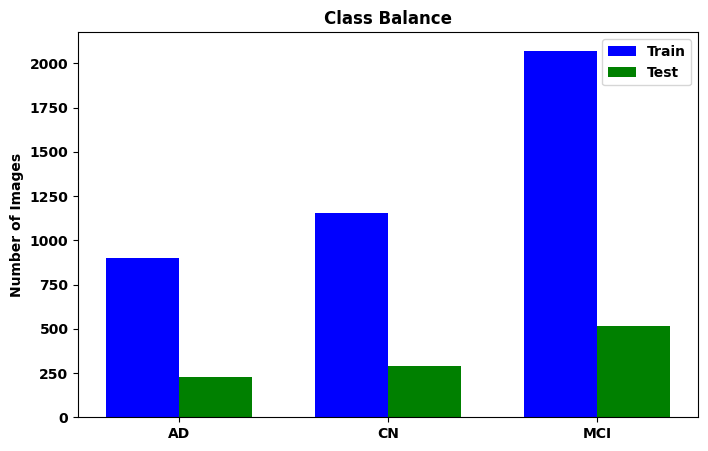

Train Counts: {'AD': 899, 'CN': 1152, 'MCI': 2072}
Test Counts: {'AD': 225, 'CN': 288, 'MCI': 518}


In [8]:
# Compute class counts
def plot_class_balance():
    train_counts = []
    test_counts = []
    for sub in subfolders:
        train_paths = get_image_paths(train_dir, sub)
        test_paths = get_image_paths(test_dir, sub)
        train_counts.append(len(train_paths))
        test_counts.append(len(test_paths))

    # Bar plot
    x = np.arange(len(subfolders))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, train_counts, width, label='Train', color='blue')
    ax.bar(x + width/2, test_counts, width, label='Test', color='green')
    ax.set_xticks(x)
    ax.set_xticklabels(subfolders)
    ax.set_title('Class Balance')
    ax.set_ylabel('Number of Images')
    ax.legend()
    plt.show()

    print("Train Counts:", dict(zip(subfolders, train_counts)))
    print("Test Counts:", dict(zip(subfolders, test_counts)))

plot_class_balance()

Leakage Check: 61 overlapping IDs (e.g., by source/filename prefix). If >0, potential leakage.
Examples: ['AD067', 'CN136', 'CI051', 'CI002', 'CN012', 'CI116', 'AD127', 'CI094', 'CN051', 'CN037', 'AD116', 'CN082', 'CI031', 'CI100', 'AD031', 'CI037', 'CN126', 'CN005', 'CN116', 'CI067', 'AD136', 'CN018', 'CN068', 'CI136', 'CN002', 'CI016', 'CN027', 'AD130', 'CI128', 'CN023', 'AD002', 'CN094', 'CI012', 'CI068', 'CN052', 'CI032', 'AD018', 'CN032', 'AD012', 'CN007', 'CI027', 'CN127', 'AD032', 'AD027', 'AD021', 'CI130', 'AD023', 'CI005', 'CI127', 'CI023', 'AD007', 'CI126', 'AD126', 'CI018', 'CN100', 'AD005', 'CN128', 'CI021', 'CI053', 'CI082', 'CN130']


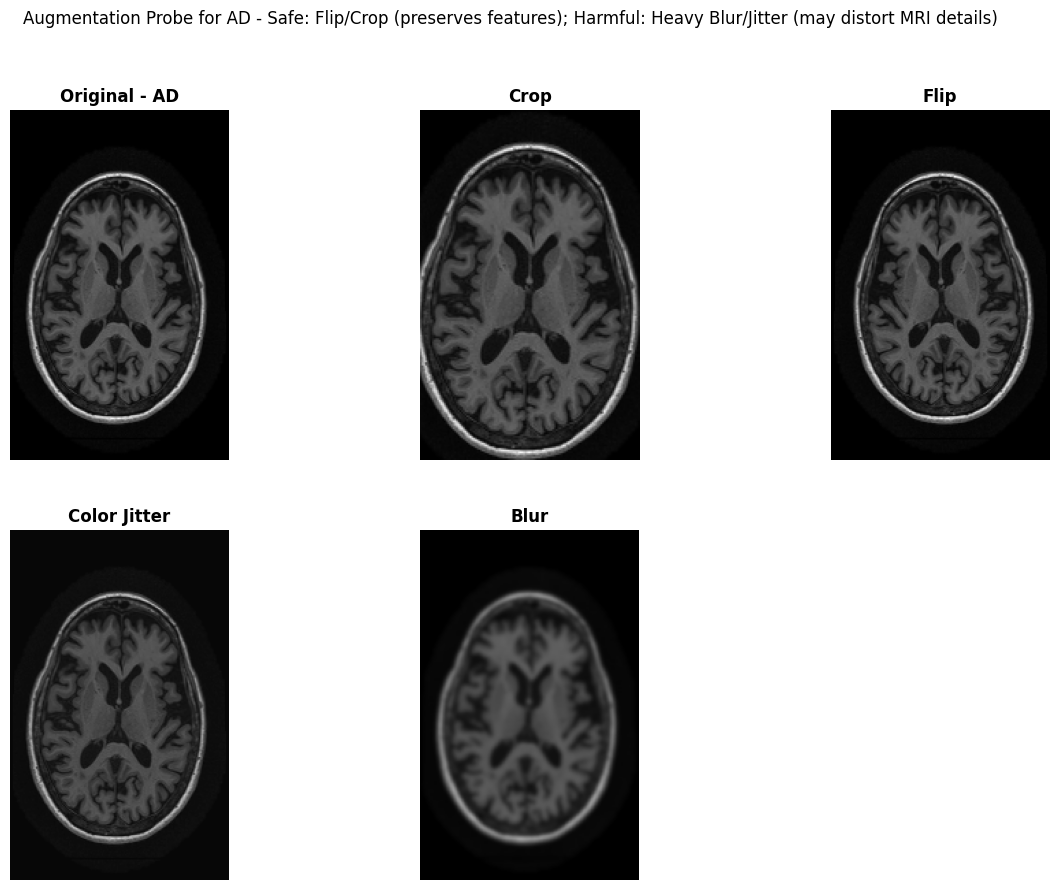

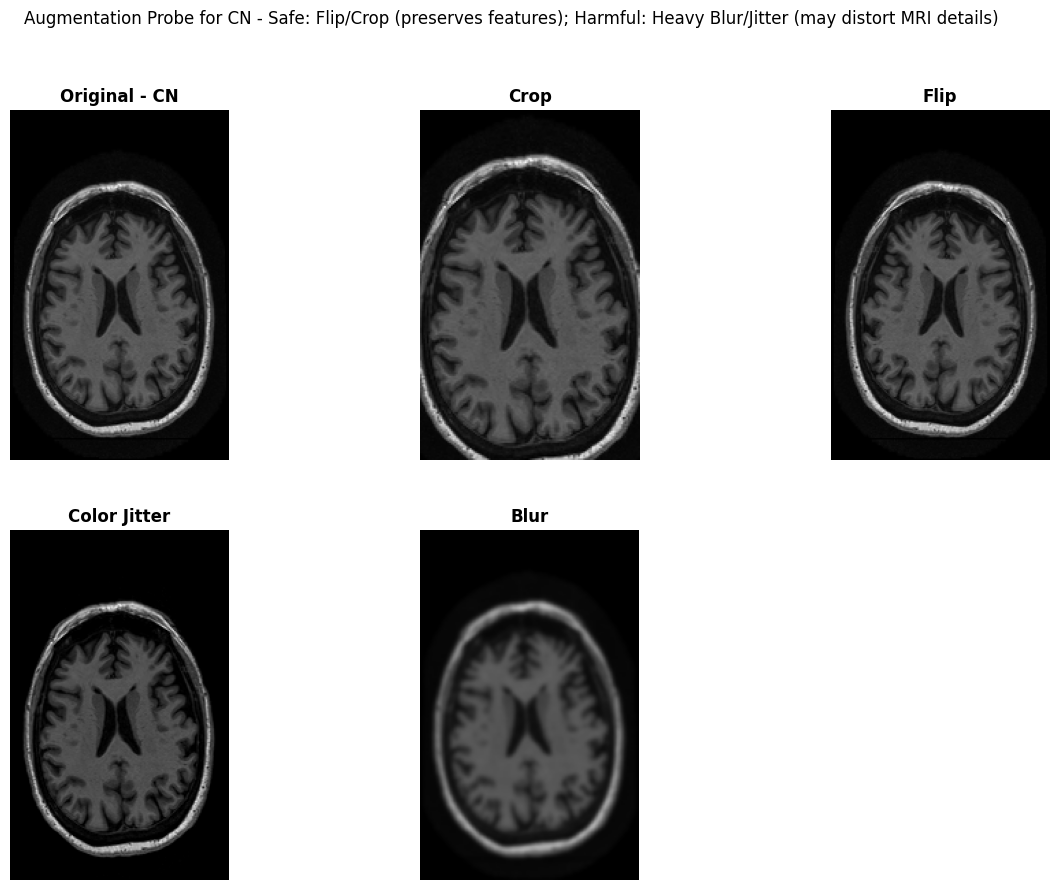

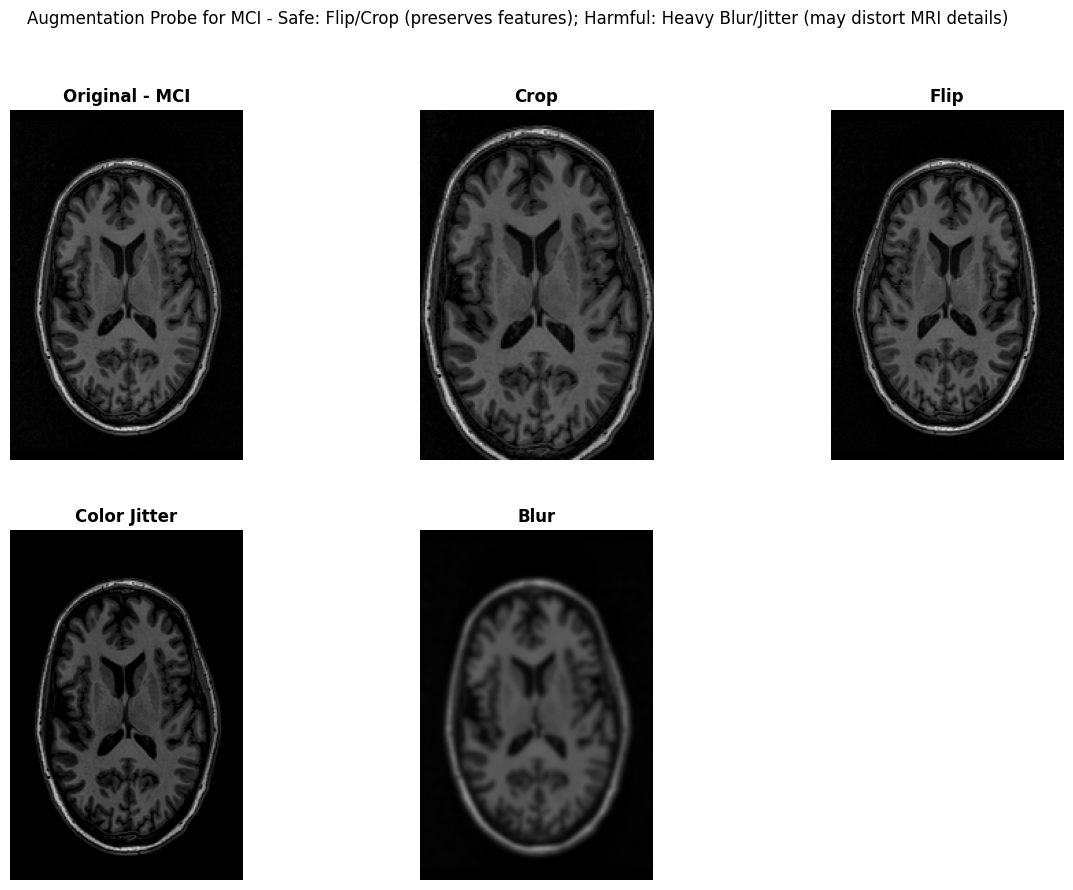

In [9]:
# Leakage check (assume filename has ID as prefix before first '_')
def check_leakage():
    train_ids = set()
    test_ids = set()
    for sub in subfolders:
        for path in get_image_paths(train_dir, sub):
            fname = os.path.basename(path)
            id_ = fname.split('_')[0] if '_' in fname else fname
            train_ids.add(id_)
        for path in get_image_paths(test_dir, sub):
            fname = os.path.basename(path)
            id_ = fname.split('_')[0] if '_' in fname else fname
            test_ids.add(id_)

    overlaps = train_ids.intersection(test_ids)
    print(f"Leakage Check: {len(overlaps)} overlapping IDs (e.g., by source/filename prefix). If >0, potential leakage.")
    if overlaps:
        print("Examples:", list(overlaps)[:100])

check_leakage()

# Augmentation probe (manual implementations)
def augmentation_probe():
    for sub in subfolders:
        paths = get_image_paths(train_dir, sub)
        if not paths:
            continue
        img_path = random.choice(paths)  # Random image
        img = np.array(Image.open(img_path).convert('RGB'))

        # Original
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 3, 1)
        plt.imshow(img)
        plt.title(f'Original - {sub}')
        plt.axis('off')

        # Crop (center 80%)
        h, w = img.shape[:2]
        crop_h, crop_w = int(h*0.8), int(w*0.8)
        cropped = img[(h-crop_h)//2:(h-crop_h)//2+crop_h, (w-crop_w)//2:(w-crop_w)//2+crop_w]
        plt.subplot(2, 3, 2)
        plt.imshow(cropped)
        plt.title('Crop')
        plt.axis('off')

        # Flip (horizontal)
        flipped = np.fliplr(img)
        plt.subplot(2, 3, 3)
        plt.imshow(flipped)
        plt.title('Flip')
        plt.axis('off')

        # Color Jitter (random brightness/contrast)
        jitter = (img.astype(float) * random.uniform(0.8, 1.2) + random.uniform(-20, 20)).clip(0, 255).astype(np.uint8)
        plt.subplot(2, 3, 4)
        plt.imshow(jitter)
        plt.title('Color Jitter')
        plt.axis('off')

        # Blur (Gaussian)
        blurred = ndimage.gaussian_filter(img, sigma=1.5)
        plt.subplot(2, 3, 5)
        plt.imshow(blurred)
        plt.title('Blur')
        plt.axis('off')

        plt.suptitle(f'Augmentation Probe for {sub} - Safe: Flip/Crop (preserves features); Harmful: Heavy Blur/Jitter (may distort MRI details)')
        plt.show()

augmentation_probe()